<H1>Notebook for identifying nucleosides in LC-MS/MS data </H1>
<H3>Used to ID non-canonical nucleosides in phage SPO1 and T4</H3>
<H4>Written by Peter Thuy-Boun with some additions by Adair Borges </H4>


In [28]:
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 100)


In [29]:
#load in csv with masses for known nucleosides and their nitrogenous bases
mass_df = pd.read_csv("mass_list_nucleosides.csv")
base_tuple_list = list(mass_df[['Nucleoside_ID', 'Base_Mass']].itertuples(index=False, name=None))
base_tuple_list

[('dC', 111.04326),
 ('dU', 112.02728),
 ('m4dC_or_m5dC', 125.0589119),
 ('dT', 126.04293),
 ('dA', 135.0545),
 ('dI', 136.0385108),
 ('5hmdC', 141.05383),
 ('hm5dU', 142.0378421),
 ('m6dA', 149.0701452),
 ('dG', 151.04941),
 ('5-NedU', 155.0694765),
 ('dPreQ1', 179.0807099),
 ('5-NeOmdU', 185.0800412),
 ('dG+_or_ncm6dA', 192.0759589),
 ('dADG', 193.0599745),
 ('5-putT', 212.1273258),
 ('5-gluT', 271.0804352),
 ('5gmdC', 303.10665),
 ('dZ', 150.0654383)]

In [30]:
#load in csv with masses for commonly seen charged adducts, their masses, and their charges
charged_adduct_df = pd.read_csv("mass_list_charged_adducts.csv")
charged_adduct_tuple_list = list(charged_adduct_df[['Adduct', 'Mass', 'Charge']].itertuples(index=False, name=None))
charged_adduct_tuple_list

[('+H', 1.00783, 1),
 ('+Na', 22.98977, 1),
 ('+K', 38.96371, 1),
 ('+Ca', 39.96259, 2),
 ('+Mg', 23.98504, 2),
 ('+2H', 2.01565, 2),
 ('+2Na', 45.97954, 2),
 ('+2K', 77.92741, 2),
 ('+H+Na', 23.99759, 2),
 ('+H+K', 39.97153, 2),
 ('+Na+K', 61.95348, 2)]

In [31]:
#load in csv with masses for commonly seen neutral adducts, and their massess
neutral_adduct_df = pd.read_csv("mass_list_neutral_adducts.csv").fillna(" ")
neutral_adduct_tuple_list = list(neutral_adduct_df[['Adduct', 'Mass']].itertuples(index=False, name=None))
neutral_adduct_tuple_list

[(' ', 0.0),
 ('+NH3', 17.02655),
 ('+CH3COOH', 58.00548),
 ('+H2O', 18.01056),
 ('+TFA', 113.99286),
 ('+MeCN', 41.02655),
 ('+MeOH', 32.02621),
 ('+PrOH', 60.05751),
 ('+2(NH3)', 34.0531),
 ('+2(CH3COOH)', 116.01096),
 ('+2(H2O)', 36.02112),
 ('+2(TFA)', 227.98572),
 ('+2(MeCN)', 82.0531),
 ('+2(MeOH)', 64.05242),
 ('+2(PrOH)', 120.11502)]

<H1>1. define functions</H1>

In [23]:
def find_nucleosides_from_ms2(high_res_ms2_file1, intens_cutoff1, ppm_tolerance1):
    ####----------Input: mgf file, ms2 intensity cutoff value (%), mass tolerance (ppm)
    ####----------Output: two dataframes, dataframe1 contains raw candidate nucleoside ms2 spectra, dataframe2 contains summarized nucleosides
    
    #-----Open mgf file
    with open(f'{high_res_ms2_file1}.mgf', 'r') as f:
        file1 = f.readlines()
    
    #-----ms2 relative intensity low % cut-off
    #--ruling out low intensity peaks that might be construed as coincidental noise
    #--%value
    intensity_percent_cutoff = intens_cutoff1

    #-----Neutral loss masses and tolerance settings
    #--stratified by charge state; since nucleosides are likely to be +1 and +2 charges, we won't consider ions of greater charge states
    #--DNA:
    neutral_loss_mass_list_charge1 = [116.0473]
    neutral_loss_mass_list_charge2 = [58.0237, 117.0552, 139.0371]
        #116.0473 = dRibose (+1; H+ or Na+; -H+ or -Na+)
        #58.0237 = dRibose(+2; 2H+ or 2Na+; -2H+ or -2Na+)
        #117.0552 = dRibose (+2; H+Na+; -H+)
        #139.0371 = dRibose (+2; H+Na+; -Na+)

    #-----Mass tolerance setting
    #--this will be spectrometer and setting dependent; here we have lock-mass Orbitrap data collected at 100,000 resolution
    #--tolerance in ppm
    mass_tolerance1 = ppm_tolerance1

    #-----Declare variables
    #---Temporary variables
    temp_scan_num = 0
    temp_retention = 0
    temp_precursor = 0
    temp_precursor_intensity = 0
    temp_charge = 0
    temp_max_ms2_intensity = 0
    temp_ms2_intensity_list1 = []
    temp_ms2_mass = 0
    temp_ms2_intensity = 0
    temp_candidate_ms2_mass_list1 = []
    temp_candidate_ms2_intensity_list1 = []
    temp_tuple1 = ()
    #---Persisent variables
    candidate_list_of_tuples = []

    #-----Collect spectrum data iterating through mgf file one ms2 spectrum at a time
    #---ms2 masses that pass filter are stored as tuples in 'candidate_list_of_tuples list variable'

    for line1 in file1:
        if 'BEGIN IONS' in line1:
            temp_scan_num = 0
            temp_retention = 0
            temp_precursor = 0
            temp_precursor_intensity = 0
            temp_charge = 0
        elif 'TITLE=' in line1:
            line2 = line1.split(' ')
            for item1 in line2:
                if 'scan=' in item1:
                    temp_scan_num = int(item1.split('scan=')[1].split('"')[0])
        elif 'RTINSECONDS=' in line1:
            temp_retention = float(line1.split('=')[1].replace('\n', ''))
        elif 'PEPMASS=' in line1:
            temp_precursor = float(line1.split(' ')[0].split('=')[1])
            temp_precursor_intensity = float(line1.split(' ')[1].replace('\n', ''))
        elif 'CHARGE=' in line1:
            temp_charge = int(line1.split('=')[1].split('+')[0])
        elif 'END ION' in line1:
            try:
                temp_max_ms2_intensity = max(temp_ms2_intensity_list1)
                temp_ms2_intensity_list1 = []
                for count, item1 in enumerate(temp_candidate_ms2_mass_list1):
                    temp_tuple1 = (temp_scan_num, temp_retention, temp_precursor, temp_precursor_intensity, temp_charge, item1, temp_candidate_ms2_intensity_list1[count], temp_max_ms2_intensity)
                    candidate_list_of_tuples.append(temp_tuple1)
                temp_tuple1 = ()
                temp_candidate_ms2_mass_list1 = []
                temp_candidate_ms2_intensity_list1 = []
            except:
                pass
        else:
            if temp_charge == 1:
                try:
                    temp_ms2_mass = float(line1.split(' ')[0])
                    temp_ms2_intensity = float(line1.split(' ')[1].replace('\n', ''))
                    temp_ms2_intensity_list1.append(temp_ms2_intensity)
                    for item1 in neutral_loss_mass_list_charge1:
                        if (abs(round(abs((temp_ms2_mass - temp_precursor)), 4) - item1)/temp_ms2_mass)*1000000 < mass_tolerance1 :
                            temp_candidate_ms2_mass_list1.append(temp_ms2_mass)
                            temp_candidate_ms2_intensity_list1.append(temp_ms2_intensity)
                except:
                    pass
            if temp_charge == 2:
                try:
                    temp_ms2_mass = float(line1.split(' ')[0])
                    temp_ms2_intensity = float(line1.split(' ')[1].replace('\n', ''))
                    temp_ms2_intensity_list1.append(temp_ms2_intensity)
                    for item1 in neutral_loss_mass_list_charge2:
                        if (abs(round(abs((temp_ms2_mass - temp_precursor)), 4) - item1)/temp_ms2_mass)*1000000 < mass_tolerance1 :
                            temp_candidate_ms2_mass_list1.append(temp_ms2_mass)
                            temp_candidate_ms2_intensity_list1.append(temp_ms2_intensity)
                except:
                    pass

    #-----Create dataframe from tuples
    #---name columns accordingly
    df1 = pd.DataFrame(candidate_list_of_tuples, columns=['scan', 'retention_sec', 'precursor_mz', 'precursor_intensity', 'charge', 'ms2_mz', 'ms2_intensity', 'ms2_max_intensity'])

    #---Calculate ms2 peak relative intensities and insert in new column
    ms2_relative_intensity_list = []
    for row1 in df1.itertuples():
        temp_var1 = round(((row1.ms2_intensity/row1.ms2_max_intensity)*100), 1)
        ms2_relative_intensity_list.append(temp_var1)
    df1['ms2_relative_intensity'] = ms2_relative_intensity_list

    #---select only rows with relative intensities above user-defined cut-off value
    df2 = df1.loc[df1['ms2_relative_intensity'] > intensity_percent_cutoff].copy()

    #---create column with rounded precursor values for grouping
    rounded_precursor_list = []
    for row1 in df2.itertuples():
        temp_var1 = round(row1.precursor_mz, 3)
        rounded_precursor_list.append(temp_var1)
    df2['rounded_precursor'] = rounded_precursor_list

    #-----Create new dataframe containing mean aggregated values (simplified list of potential nucleosides)
    df3 = df2.groupby('rounded_precursor').mean()
    df3 = df3[['precursor_mz', 'precursor_intensity', 'charge', 'ms2_mz', 'ms2_intensity', 'ms2_max_intensity', 'ms2_relative_intensity']]
    df3['charge'] = df3['charge'].astype(int)
    df3['ms2_relative_intensity'] = df3['ms2_relative_intensity'].round(1)
    
    #-----Add file column to denote file or origin
    df1['filename'] = high_res_ms2_file1
    df2['filename'] = high_res_ms2_file1
    df3['filename'] = high_res_ms2_file1

    #-----Dataframe key:
    #df1: raw dataframe
    #df2: dataframe with selected values (above relative intensity threshold)
    #df3: dataframe containing aggregate precursor values (simplified)
    
    return df1, df3

def assign_Nucleotides_to_Masses(query_mass1, query_tol1):
    ####----------Input: Nucleotide mass (query_mass1) and ppm tolerance (query_tol1)
    ####----------Output: list of strings describing outcome of mass query (nucleotide base or unknown)
    #-----Reference lists created above from mass csvs
   
    #-----Declare variables
    list_of_hits1 = []
    #-----Iterate through mass combinations
    for item1 in charged_adduct_tuple_list:
        for item2 in neutral_adduct_tuple_list:
            for item3 in base_tuple_list:
                if (abs(query_mass1 - ((item3[1] + item2[1] + item1[1])/item1[2]))/query_mass1)*1000000 < query_tol1:
                    temp_identity1 = str('[' + item3[0] + item2[0] + item1[0] + ']')
                    list_of_hits1.append(temp_identity1)
    return list_of_hits1
    



<H1>2. list and process .mgf files</H1>

In [24]:
#------mgf files to read-in
filename_list = ['ORB59709', 'ORB59710']
filename_corresponding_sample_list = [('ORB59709', 'SP01'),('ORB59710', 'T4')]

#------create empty dataframes
combined_raw_results = pd.DataFrame()
combined_summary_results = pd.DataFrame()

#------load up empty dataframes with nucleoside candidates
for item1 in filename_list:
    df_A, df_B = find_nucleosides_from_ms2(item1, 5, 10)
    combined_raw_results = pd.concat([combined_raw_results, df_A])
    combined_summary_results = pd.concat([combined_summary_results, df_B])

#------assign identities to nucleoside candidates (when possible)
identity_column1 = []
filename_to_sample_column1 = []

for row1 in combined_summary_results.itertuples():
    temp_list2 = assign_Nucleotides_to_Masses(row1.ms2_mz, 20)
    identity_column1.append(temp_list2)
    for item1 in filename_corresponding_sample_list:
        if item1[0] == row1.filename:
            temp_sample_name2 = item1[1]
    filename_to_sample_column1.append(temp_sample_name2)

combined_summary_results['sample'] = filename_to_sample_column1
combined_summary_results['candidate_ID'] = identity_column1



<H1>3. output nucleoside candidates</H1>

In [25]:
combined_raw_results

,scan,retention_sec,precursor_mz,precursor_intensity,charge,ms2_mz,ms2_intensity,ms2_max_intensity,ms2_relative_intensity,filename
0,35,93.9185,250.079758,1.476111e+06,1,134.031876,2.773924e+03,4.864856e+03,57.0,ORB59709
1,38,102.7485,287.146179,4.148803e+05,1,171.098618,1.177274e+02,3.446895e+03,3.4,ORB59709
2,41,111.0570,281.074341,1.776593e+07,1,165.026749,1.123107e+06,1.123107e+06,100.0,ORB59709
3,41,111.0570,281.074341,1.776593e+07,1,165.028030,8.480890e+03,1.123107e+06,0.8,ORB59709
4,44,118.5086,541.135620,1.805165e+06,1,425.088135,1.842402e+04,4.285788e+04,43.0,ORB59709
...,...,...,...,...,...,...,...,...,...,...
99,428,1189.9517,252.108994,1.849116e+05,1,136.060745,3.660362e+02,1.132755e+04,3.2,ORB59710
100,428,1189.9517,252.108994,1.849116e+05,1,136.061386,1.132755e+04,1.132755e+04,100.0,ORB59710
101,435,1209.6812,252.108994,1.708133e+05,1,136.060425,1.526801e+02,9.459137e+03,1.6,ORB59710
102,435,1209.6812,252.108994,1.708133e+05,1,136.061371,9.459137e+03,9.459137e+03,100.0,ORB59710


<H1>4. summarize findings between all samples</H1>

In [26]:
combined_summary_results.sort_values("precursor_mz")

,precursor_mz,precursor_intensity,charge,ms2_mz,ms2_intensity,ms2_max_intensity,ms2_relative_intensity,filename,sample,candidate_ID
rounded_precursor,,,,,,,,,,
243.098,243.097610,8.067196e+05,1,127.049789,4.952792e+03,7.959023e+03,62.2,ORB59710,T4,[[dT +H]]
250.080,250.079758,1.476111e+06,1,134.031876,2.773924e+03,4.864856e+03,57.0,ORB59709,SP01,"[[dC +Na], [dG+_or_ncm6dA+2(H2O)+Ca], [dG+_or_ncm6dA+2(H2O)+H+K]]"
252.109,252.109013,1.192258e+06,1,136.061539,3.174116e+05,3.206475e+05,86.3,ORB59709,SP01,[[dA +H]]
252.109,252.109027,3.523865e+06,1,136.061558,3.378851e+05,3.414013e+05,89.2,ORB59710,T4,[[dA +H]]
265.079,265.079437,8.538831e+06,1,149.032181,1.818521e+04,4.626053e+04,29.5,ORB59710,T4,[[dT +Na]]
266.125,266.124837,5.890441e+05,1,150.077459,2.301265e+04,2.581470e+04,69.8,ORB59710,T4,[[m6dA +H]]
268.104,268.103973,3.785444e+05,1,152.056381,1.888525e+04,1.888525e+04,100.0,ORB59709,SP01,[[dG +H]]
268.104,268.104126,2.945215e+06,1,152.056656,3.423027e+05,3.423027e+05,100.0,ORB59710,T4,[[dG +H]]
274.091,274.091064,1.847553e+06,1,158.043526,7.183229e+02,4.187823e+03,17.2,ORB59709,SP01,[[dA +Na]]


<H1>5. precursor vs fragment m/z scatter plot</H1>

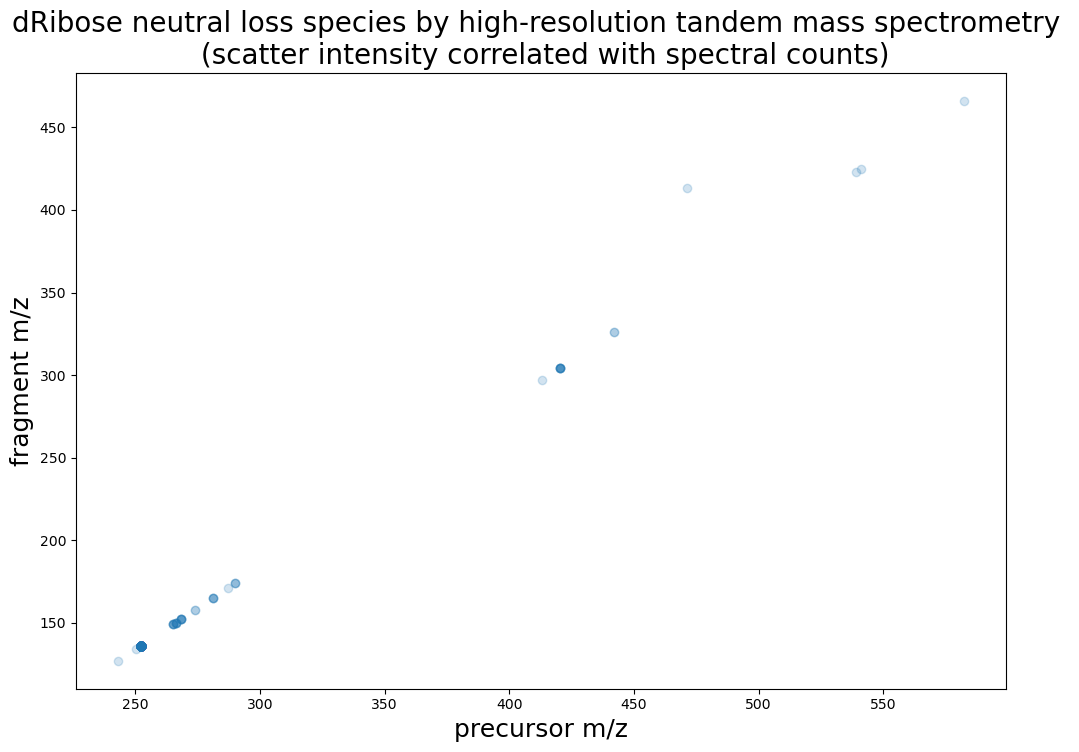

In [27]:

#----------Scatter plot
plt.subplots(figsize=(12,8))
plt.scatter(combined_raw_results['precursor_mz'], combined_raw_results['ms2_mz'], alpha=0.2)
plt.xlabel('precursor m/z', size=18)
plt.ylabel('fragment m/z', size=18)
plt.title('dRibose neutral loss species by high-resolution tandem mass spectrometry \n (scatter intensity correlated with spectral counts)', size=20)
plt.savefig('dRibose_neutral_loss_scatter.jpg')



<H1>6. output .csv files</H1>

In [10]:
combined_raw_results.to_csv('dRibose_neutral_loss_combined_raw_results.csv', index=False)
combined_summary_results.to_csv('dRibose_neutral_loss_summary_results.csv', index=False)